<a href="https://colab.research.google.com/github/JasonThMdl/Thesis/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade pandas
from pandas._libs.lib import map_infer_mask
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime,date,timedelta
import pickle
import sys, os
from contextlib import contextmanager
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import math
import warnings
warnings.filterwarnings("ignore")

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

def calculate_smape(actual, predicted) -> float:
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

def get_date_range(df,span):
  min_date=df.min()
  max_date=df.max()
  list_dates=[]
  x=min_date

  while x<max_date:
    list_dates.append(x)
    x=x+timedelta(span)
  return list_dates


def fill_missing_values(df,lst):
  set1 = set(lst)
  set2 = set(df.index)
  missing = list(sorted(set1 - set2))
  #print(missing)
  for i in range(len(missing)):
    #row = pd.Series({'products_quantity':1,'price_per_unit':df['price_per_unit'].mean()},name=missing[i])
    row = pd.Series({'products_quantity':0,'price_per_unit':0},name=missing[i])
    with suppress_stdout():
      df= df.append(row)
  return df




df_metrics=pd.DataFrame()

def metrics(i,test,prediction_test,final):
    #print(i)
    #print(test)
    #print(prediction_test)
    #print(final)
    df_metrics.at[i,"MAE_ARIMA"]=(mean_absolute_error(test,prediction_test))
    df_metrics.at[i,"MAE_Hybrid"]=(mean_absolute_error(test,final))
    df_metrics.at[i,"RMSE_ARIMA"]=(math.sqrt(mean_squared_error(test, prediction_test)))
    df_metrics.at[i,"RMSE_Hybrid"]=(math.sqrt(mean_squared_error(test, final)))
    df_metrics.at[i,"MSE_ARIMA"]=(mean_squared_error(test,prediction_test))
    df_metrics.at[i,"MSE_Hybrid"]=(mean_squared_error(test,final))
    df_metrics.at[i,"MAPE_ARIMA"]=(mean_absolute_percentage_error(test,prediction_test))
    df_metrics.at[i,"MAPE_Hybrid"]=(mean_absolute_percentage_error(test,final))
    df_metrics.at[i,"SMAPE_ARIMA"]=calculate_smape(test, prediction_test)[0]
    df_metrics.at[i,"SMAPE_Hybrid"]=calculate_smape(test, final)[0]
    

with suppress_stdout():
  !pip install pmdarima
from pmdarima.arima import auto_arima


drive.mount('/content/drive')
file_name='important'
path='/content/drive/MyDrive/Thesis/New_Code/important'
path_to_embed=os.path.join(path,file_name)
data=pickle.load(open(path,"rb"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 4.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Mounted at /content/drive


3423a5519d610bf8b02cd21e3da7f5d3
1/1 [==============================] - 1s 560ms/step
48b9163d797ee88e2209944d8e99403f
1/1 [==============================] - 1s 616ms/step
766c9f25a97bc6fcc49a712a8a4afaa5


1/1 [==============================] - 1s 584ms/step
8d99cad08ac182f2ce41b1d79abf608c


1/1 [==============================] - 1s 646ms/step
d7f045a918cc8d31fa47f337b6ca4df2
1/1 [==============================] - 1s 593ms/step
600c140b489589e9e5c044cfdc43e6fb
1/1 [==============================] - 1s 655ms/step
69465f7c3a07a55e9b6ed2ed801389ad
1/1 [==============================] - 1s 593ms/step
6b5b9ef46f709c9f1e6ddb108ecd7ede
1/1 [==============================] - 1s 606ms/step
59f6573d226bf3c7eb57d89a89bc3cf7
1/1 [==============================] - 1s 574ms/step
bb41cedb77aa1dbe1837580bc009e46b
1/1 [==============================] - 1s 672ms/step


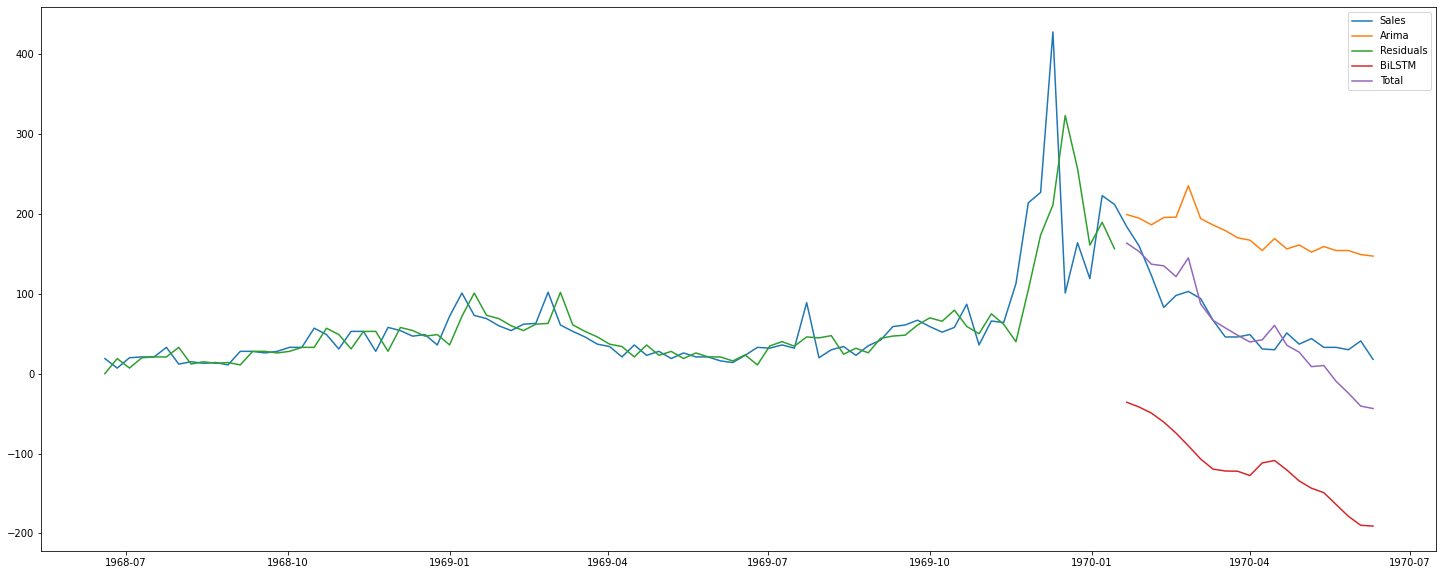

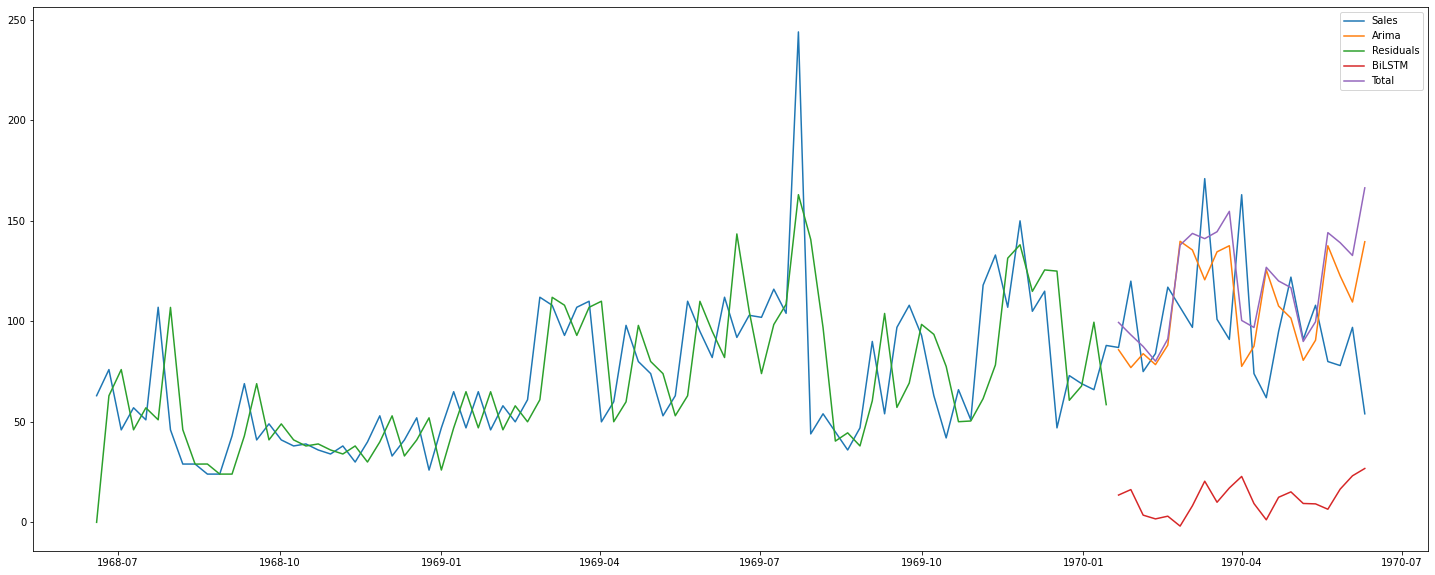

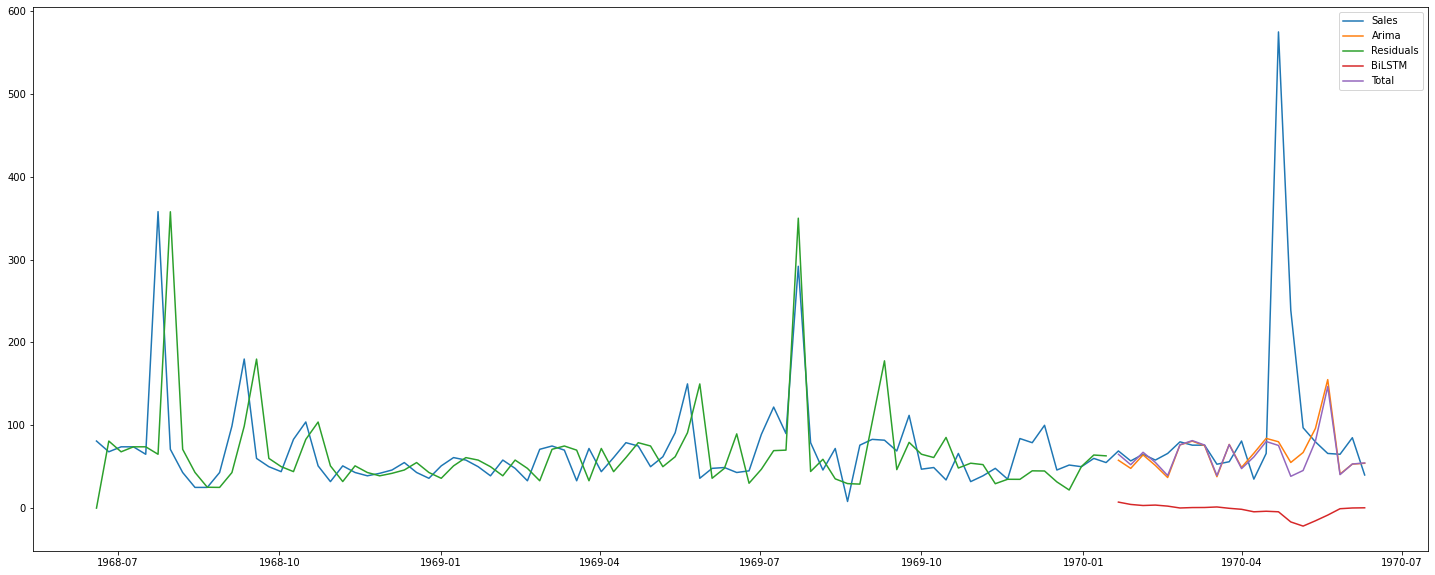

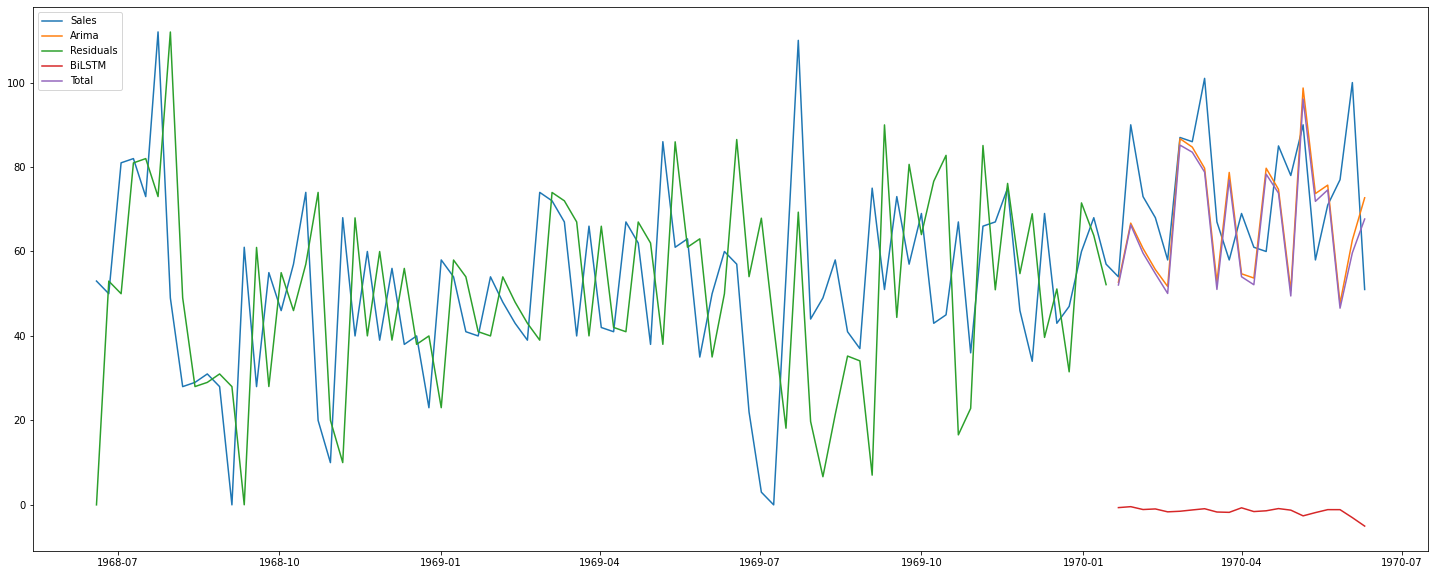

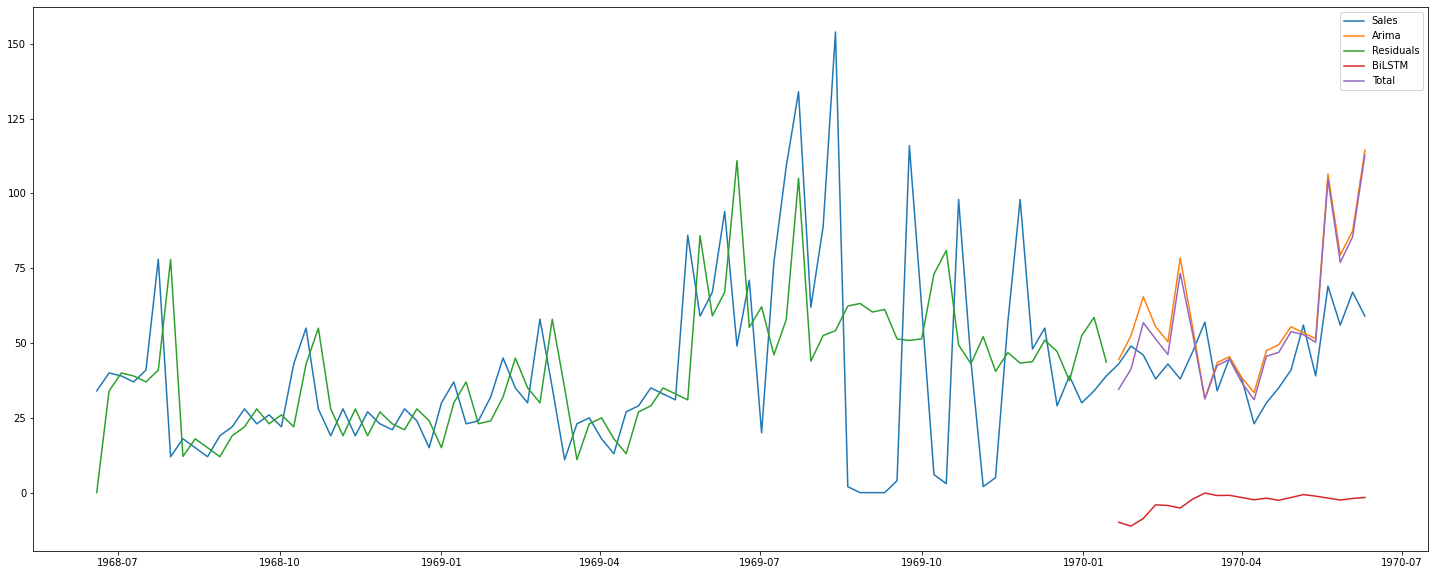

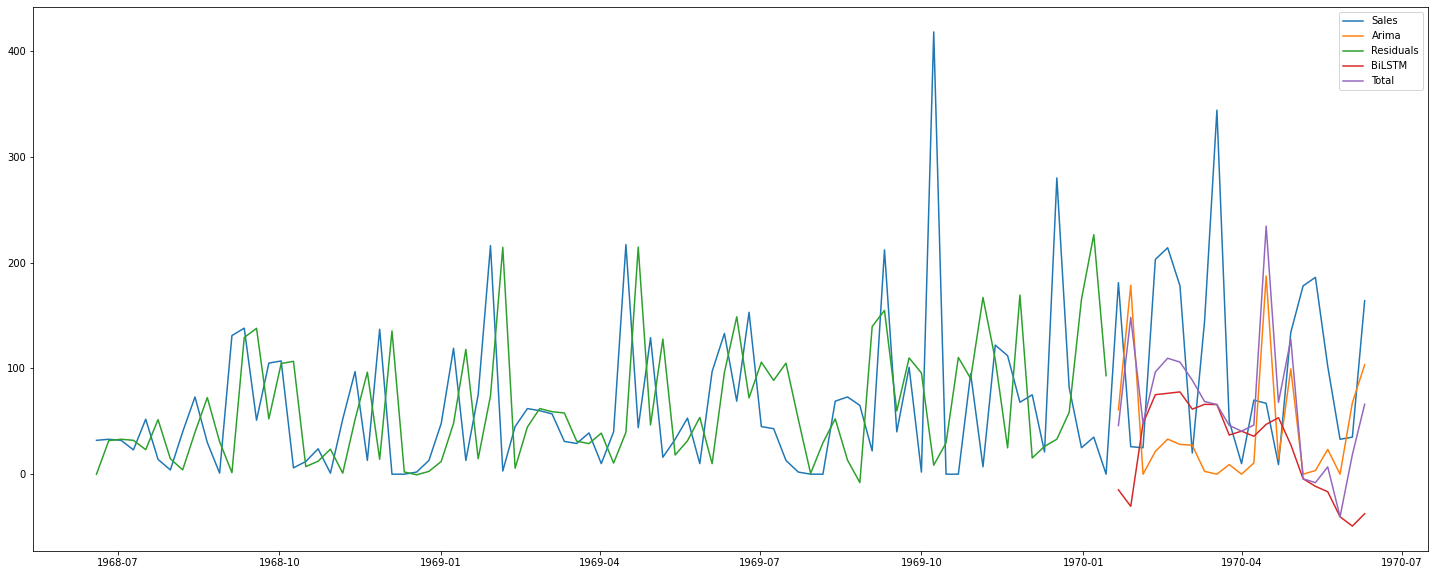

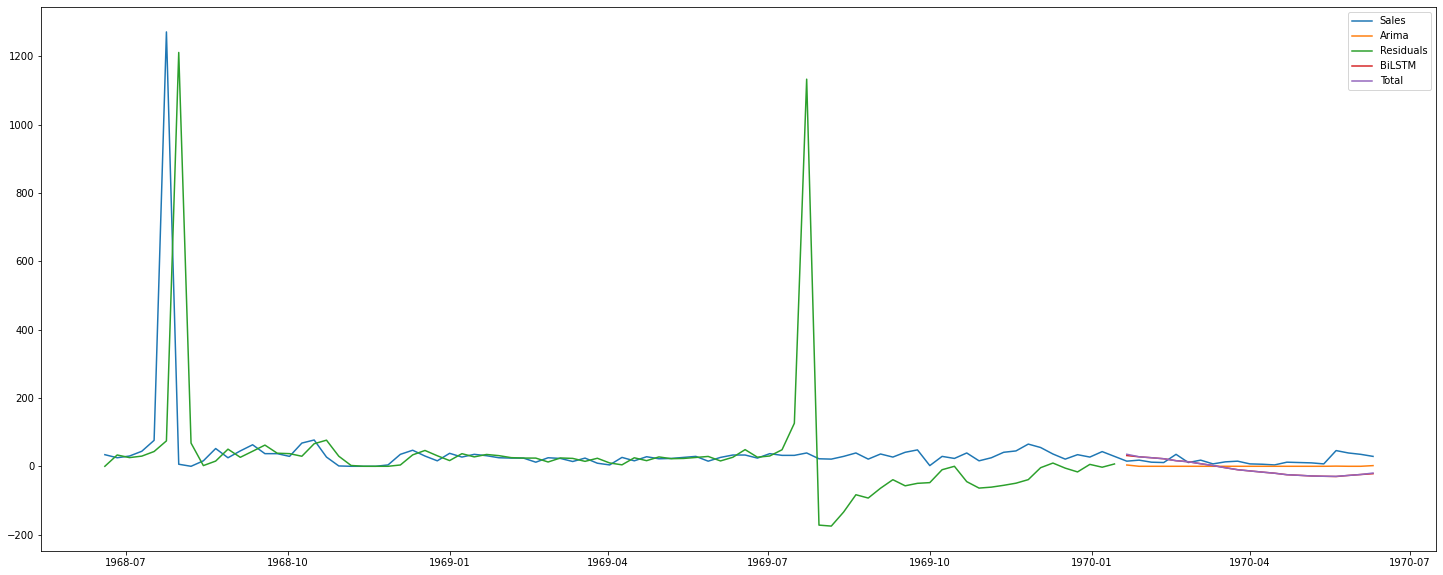

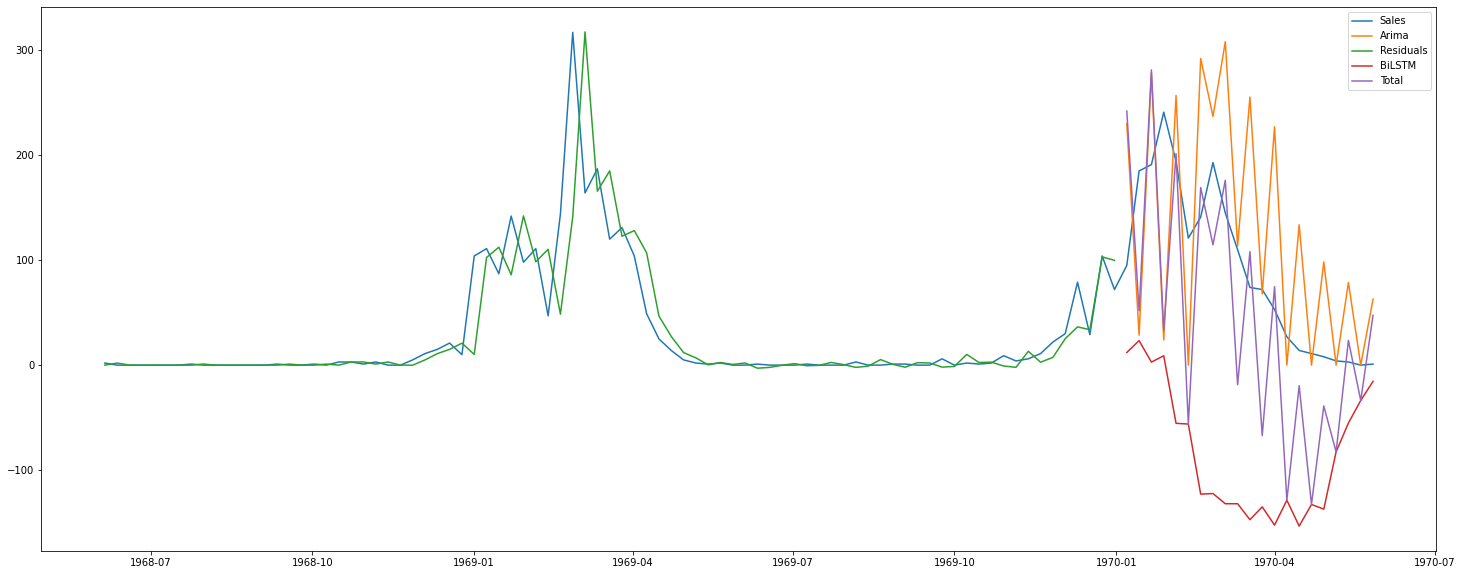

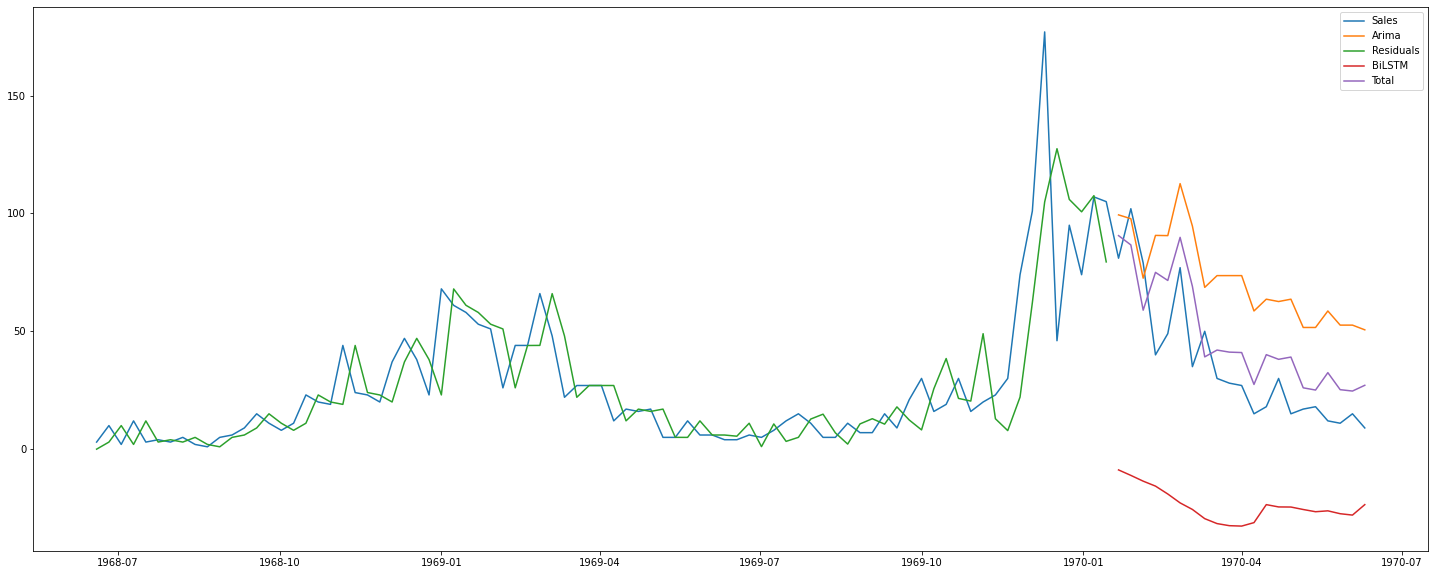

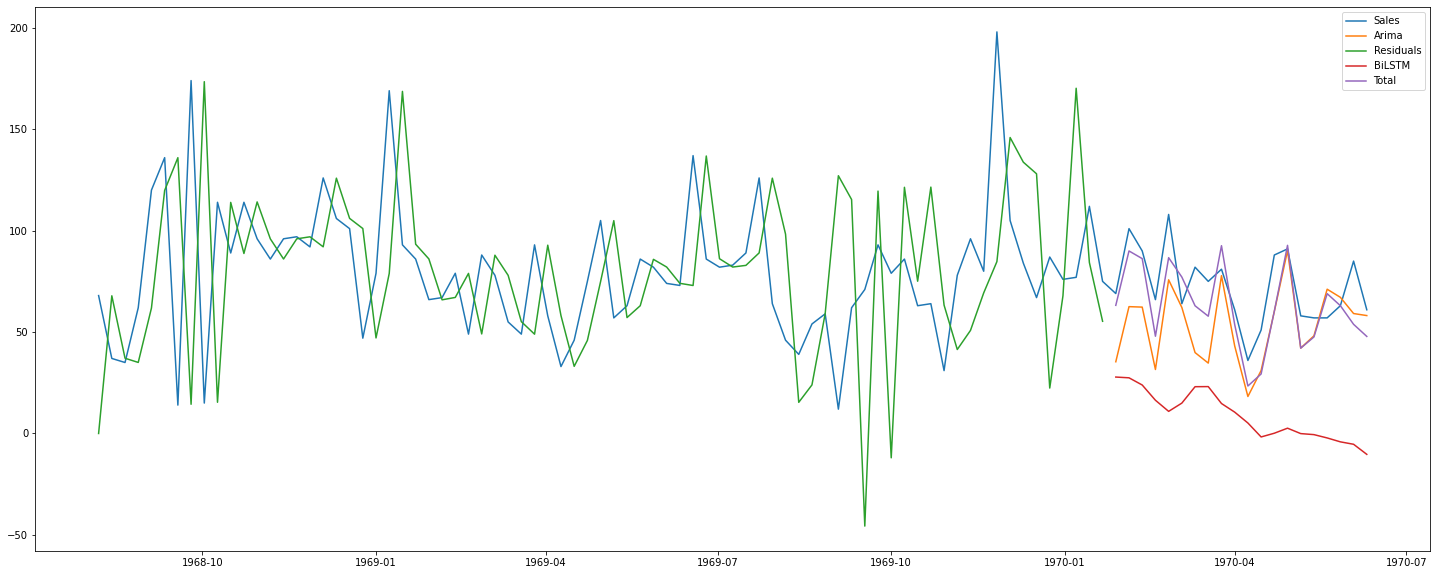

In [6]:
df_metrics=pd.DataFrame()
list_errors=[]
df_temp=pd.DataFrame()
counter=-1

for i in (data.products_id.unique()[0:10]):
 
 ######################ARIMA################################
  counter+=1
  print(i)
  df_temp=data[data['products_id']==i].reset_index(drop=True)
  list_dates=get_date_range(df_temp.date_purchased,7)
  df_temp=df_temp.drop(labels=['products_id'],axis=1)
  df_temp.set_index('date_purchased',inplace=True)
  df_temp = fill_missing_values(df_temp,list_dates)
  df_temp=df_temp.sort_index()


  if len(df_temp)>104:
     df_temp=df_temp.iloc[len(df_temp)-104:]
  

  size = int(len(df_temp) * 0.8)
  train, test = df_temp.products_quantity[0:size], df_temp.products_quantity[size:len(df_temp)] 

  with suppress_stdout():
    model_arima =  auto_arima(train,start_p=0, d=1, start_q=0, 
                                      max_p=5, max_d=2, max_q=3, start_P=0, 
                                      D=1, start_Q=0, max_P=3, max_D=2,
                                      max_Q=3, m=52, seasonal=True, 
                                      error_action='ignore',trace = True,
                                      supress_warnings=True,stepwise = True)
  

  prediction_train=model_arima.predict_in_sample()
  prediction_test, confint = model_arima.predict(len(test), return_conf_int=True)


  prediction_train=prediction_train.to_frame()
  prediction_test=prediction_test.to_frame()
  prediction_test[prediction_test<0]=0
  prediction_test.columns=prediction_train.columns

  #####################BiLSTM################################
  df_bilstm=pd.concat([prediction_train,prediction_test],ignore_index=True)
  df_bilstm['predicted_mean']=pd.concat([train,test],ignore_index=True)-df_bilstm['predicted_mean']
  df_bilstm['price_per_unit']=df_temp['price_per_unit'].to_numpy()


  scaler=StandardScaler()
  scaler=scaler.fit(df_bilstm)
  df_bilstm_scaled=scaler.transform(df_bilstm)


  trainX=[]
  trainY=[]

  n_future=1
  n_past=16

  for z in range(n_past, len(df_bilstm_scaled) - n_future +1):
      trainX.append(df_bilstm_scaled[z - n_past:z, 0:df_bilstm.shape[1]])
      trainY.append(df_bilstm_scaled[z + n_future - 1:z + n_future, 0])


  trainX, trainY = np.array(trainX), np.array(trainY)

  #print('trainX shape == {}.'.format(trainX.shape))
  #print('trainY shape == {}.'.format(trainY.shape))

  model = Sequential()
  model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
  model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
  model.add(Dropout(0.2))
  model.add(Dense(trainY.shape[1]))

  model.compile(optimizer='adam', loss='mse')
  with suppress_stdout():
    history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)
  prediction = model.predict(trainX[-len(test):]) #shape = (n, 1) where n is the n_days_for_prediction
  prediction_copies = np.repeat(prediction, df_bilstm.shape[1], axis=-1)
  y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

  '''
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.legend()
  '''


  metrics(counter,test.to_frame().values,prediction_test,prediction_test+pd.DataFrame(y_pred_future).values) #metrics dataframe creating function

  #########Plotting################
  fig, ax = plt.subplots(1, 1, figsize=(25, 10))
  ax.plot(df_temp.products_quantity)
  ax.plot(prediction_test)
  ax.plot(prediction_train)
  df_copy=prediction_test.copy()
  df_copy['predictions_lstm'] = pd.DataFrame(y_pred_future).values
  df_copy.drop(columns = df_copy.columns[0], axis = 1, inplace= True)
  ax.plot(df_copy)
  ax.plot(prediction_test+pd.DataFrame(y_pred_future).values)
  ax.legend(['Sales', 'Arima','Residuals','BiLSTM','Total'])      

3423a5519d610bf8b02cd21e3da7f5d3
Estimated coefficients:
b_0 = 335.8278390825284            
b_1 = -10.121471663367464


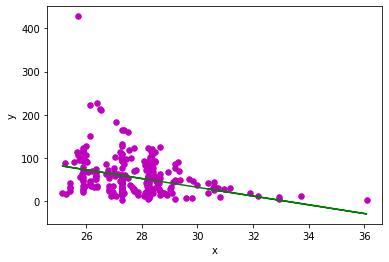

48b9163d797ee88e2209944d8e99403f
Estimated coefficients:
b_0 = 13.356698906911419            
b_1 = 2.1464801984841064


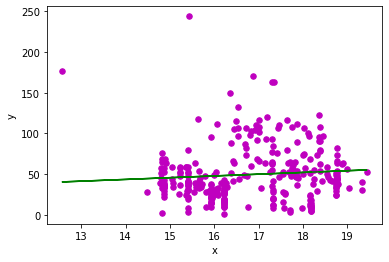

766c9f25a97bc6fcc49a712a8a4afaa5
Estimated coefficients:
b_0 = 325.5244513782469            
b_1 = -17.52220224518427


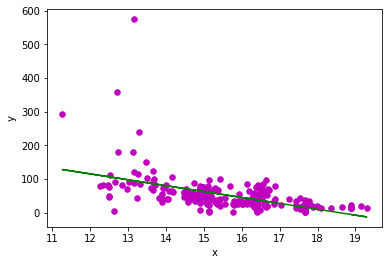

8d99cad08ac182f2ce41b1d79abf608c
Estimated coefficients:
b_0 = 107.63257157784079            
b_1 = -3.5174181548219723


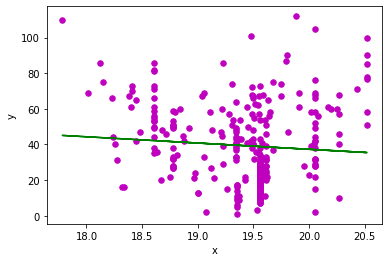

d7f045a918cc8d31fa47f337b6ca4df2
Estimated coefficients:
b_0 = -8.769780313112143            
b_1 = 3.730607702762129


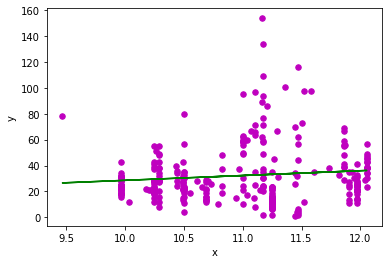

600c140b489589e9e5c044cfdc43e6fb
Estimated coefficients:
b_0 = -17.31602906997516            
b_1 = 153.10308185000477


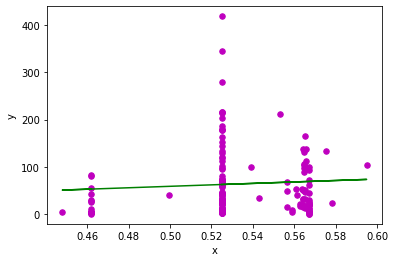

69465f7c3a07a55e9b6ed2ed801389ad
Estimated coefficients:
b_0 = 290.69760043175506            
b_1 = -96.48196950744459


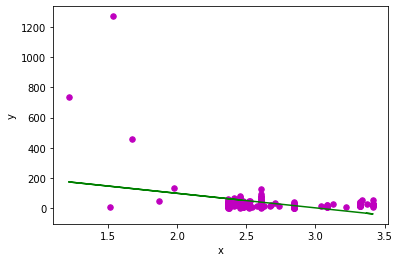

6b5b9ef46f709c9f1e6ddb108ecd7ede
Estimated coefficients:
b_0 = 328.3199431191365            
b_1 = -12.4751511229618


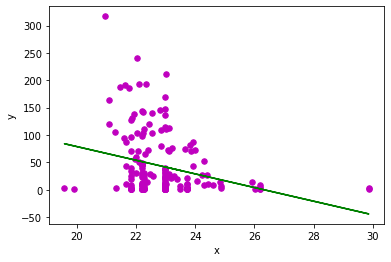

59f6573d226bf3c7eb57d89a89bc3cf7
Estimated coefficients:
b_0 = 140.02008921633575            
b_1 = -4.735346711378934


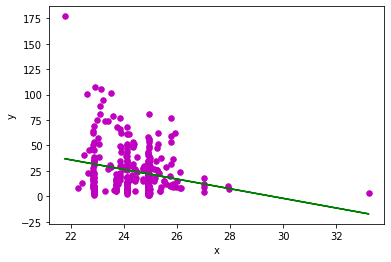

bb41cedb77aa1dbe1837580bc009e46b
Estimated coefficients:
b_0 = 185.50211369286066            
b_1 = -4.9223674306166405


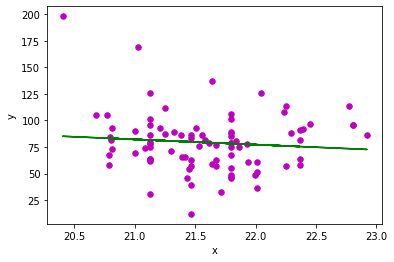

In [ ]:
for i in (data.products_id.unique()[0:10]):
 
 ######################ARIMA################################
  print(i)
  df_temp=data[data['products_id']==i].reset_index(drop=True)
  list_dates=get_date_range(df_temp.date_purchased,7)
  df_temp=df_temp.drop(labels=['products_id'],axis=1)
  df_temp.set_index('date_purchased',inplace=True)
  df_temp=df_temp.sort_index()
  df_temp=df_temp[int(0.1*len(df_temp)):]
  main(df_temp)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
  
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)
  
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 30)
  
    # predicted response vector
    y_pred = b[0] + b[1]*x
  
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
  
    # putting labels
    plt.xlabel('x')
    plt.ylabel('y')
  
    # function to show plot
    plt.show()
  
def main(df_temp):
    # observations / data
    x = df_temp['price_per_unit']
    y = df_temp['products_quantity']
  
    # estimating coefficients
    b = estimate_coef(x, y)
    print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(b[0], b[1]))
  
    # plotting regression line
    plot_regression_line(x, y, b)
  


In [ ]:
df_metrics


In [ ]:
df_metrics=pd.DataFrame()
list_errors=[]
df_temp=pd.DataFrame()
counter=-1
cs=0
ci=0
ce=0
cl=0
for i in (data.products_id.unique()[0:10]):
 
 ######################ARIMA################################
  counter+=1
  print(counter)
  df_temp=data[data['products_id']==i].reset_index(drop=True)
  list_dates=get_date_range(df_temp.date_purchased,7)
  df_temp=df_temp.drop(labels=['products_id'],axis=1)
  df_temp.set_index('date_purchased',inplace=True)
  df_temp = fill_missing_values(df_temp,list_dates)
  df_temp=df_temp.sort_index()
  if len(df_temp)>1:
    CV_2=(statistics.stdev(df_temp['products_quantity'])/df_temp['products_quantity'].mean())**2
    ADI=len(df_temp)/len(df_temp[df_temp['products_quantity']!=0])
    if ADI<1.32 and CV_2<0.49:
      print('smooth')
    elif ADI>=1.32 and CV_2<0.49:
      print('intermitten')
    elif ADI<1.32 and CV_2>=0.49:
      print('erratic')
    else:
      print('lumpy')